# Least squares regression using gradient descent

We will apply a least squares regression using gradient descent. The idea is to find the optimal parameters of a function

$
y = f(x) = ax+b
$

that best adjusts to a dataset.

### Generate the data

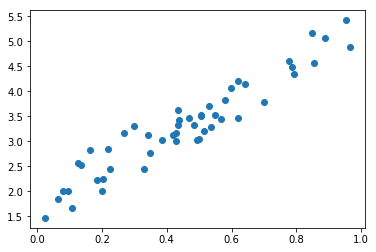

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)

N = 50

x_data = np.random.rand(N)
y_data = 3.4*x_data+1.3+np.random.rand(N)

plt.figure()
plt.plot(x_data, y_data, 'o')

### Propose some initial value for parameters $a$ and $b$

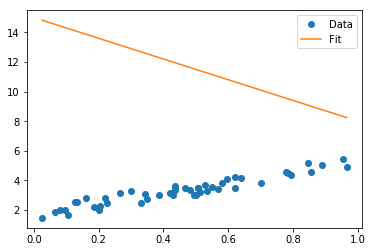

In [17]:
slope = -7 #np.random.rand()
intercept = 15 #np.random.rand() 
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = slope*x_fit + intercept

plt.figure()
plt.plot(x_data, y_data, 'o')
plt.plot(x_fit, y_fit)
plt.legend(('Data', 'Fit'))

### Define the function that provides the error of the linear regression

The function is given by

$
L=\sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_d(i)-y_e(i))^2}
$


where $y_d(i)$ is the $y$ value obtained for object $i$ and $y_e(i)$ is given by

$
y_e(i) = ax_d(i)+b
$

where $x_d(i)$ is the $x$ value measured for object $i$.

In [18]:
def get_error(x_data, y_data, intercept, slope):
    
    num_points = x_data.size
    error = 0
    for idx in range(num_points):
        error += (slope*x_data[idx]+intercept - y_data[idx])**2
        
    return np.sqrt(error/num_points)

print(get_error(x_data, y_data, intercept, slope))

8.906238775493145


### Local error surface

We will analyse the local values of the error around the current parameters

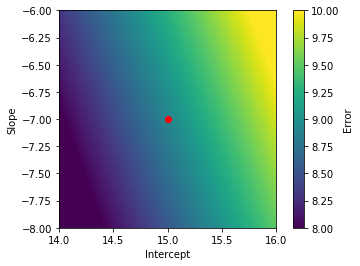

In [19]:
def get_local_error(x_data, y_data, intercept, slope,
                    range_intercept=1, range_slope=1, size=200):
    '''Calculate the regression error around the current intercept and slope.'''
    
    loc_slope = np.linspace(slope-range_slope, slope+range_slope, size)
    loc_intercept = np.linspace(intercept-range_intercept, intercept+range_intercept, size)
    local_error = np.zeros((size, size))
    for row, sl in enumerate(loc_slope):
        for col, ipt in enumerate(loc_intercept):
            local_error[row, col] = get_error(x_data, y_data, ipt, sl)  # Invert y because origin is at lower left
    
    return local_error, loc_intercept, loc_slope

def plot_local_error(x_data, y_data, intercept, slope, vmin=8, vmax=10):
    
    local_error, X, Y = get_local_error(x_data, y_data, intercept, slope)
    
    plt.figure()
    plt.subplot(111, aspect='equal')
    plt.pcolormesh(X, Y, local_error, vmin=vmin, vmax=vmax)
    plt.plot([intercept], [slope], 'ro')
    cbar = plt.colorbar()
    cbar.set_label('Error')
    plt.xlabel('Intercept')
    plt.ylabel('Slope')


plot_local_error(x_data, y_data, intercept, slope)

### Gradient computation and visualization

We can compute the gradient using two methods:

1\. Using finite differences

We calculate 

$
L(a,b) = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_d(i)-ax_d(i)-b)^2}
$

Define some small change to one of the parameters and calculate the new error

$
L(a+\Delta a,b) = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_d(i)-(a+\Delta a)x_d(i)-b)^2}
$

The derivative of $L$ with respect to $a$ is then approximated as

$
\large
\frac{\partial{L}}{\partial{a}} \approx \frac{L(a+\Delta a,b)-L(a,b)}{\Delta a}
$

For instance, we could use $\Delta a=0.001$. The same process is done to parameter $b$.

2\. Using the known derivative

We do not need to calculate the gradient numerically, because we can find the exact expression for the derivatives:

$
\frac{\partial{L}}{\partial{a}} = -\left[N\sum_{i=1}^N e(i)^2\right]^{-1/2}\sum_{i=1}^N e(i)x_d(i)
$

$
\frac{\partial{L}}{\partial{b}} = -\left[N\sum_{i=1}^N e(i)^2\right]^{-1/2}\sum_{i=1}^N e(i)
$

where $e(i)=y_d(i)-ax_d(i)-b$.

But we will use the finite difference method for calculating the gradient.


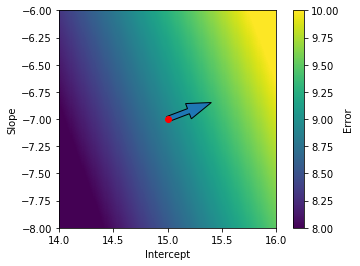

In [20]:
def calculate_gradient(x_data, y_data, intercept, slope, dintercept=0.01, dslope=0.01):
    '''Calculate the gradient of the error function using finite differences'''
    
    error = get_error(x_data, y_data, intercept, slope)
    error_dintercept = get_error(x_data, y_data, intercept+dintercept, slope)
    error_dslope = get_error(x_data, y_data, intercept, slope+dslope)

    derror_dslope = (error_dslope-error)/dslope
    derror_dintercept = (error_dintercept-error)/dintercept
    gradient = np.array((derror_dintercept, derror_dslope))
    return gradient

def calculate_gradient_analytical(x_data, y_data, intercept, slope, dintercept=0.01, dslope=0.01):
    '''Calculate the gradient of the error function using the analytic functions shown above'''
    
    num_points = x_data.size
    squared_error = 0
    error = 0
    error_x_data = 0
    for idx in range(num_points):
        e = y_data[idx] - slope*x_data[idx]-intercept
        squared_error += e**2
        error_x_data += e*x_data[idx]
        error += e
    derrordslope = -(num_points*squared_error)**(-0.5)*error_x_data
    derrordintercept = -(num_points*squared_error)**(-0.5)*error
        
    gradient = np.array((derrordintercept, derrordslope))
    return gradient
    
gradient = calculate_gradient(x_data, y_data, intercept, slope)
gradient_normalized = 0.2*gradient

plot_local_error(x_data, y_data, intercept, slope)
plt.arrow(intercept, slope, gradient_normalized[0], gradient_normalized[1], width=0.05)


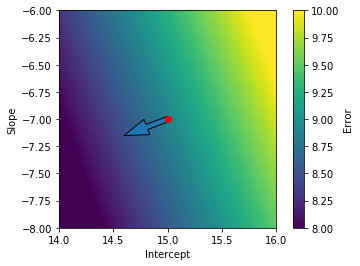

In [21]:
# We want to move in the negative direction of the gradient
plot_local_error(x_data, y_data, intercept, slope)
plt.arrow(intercept, slope, -gradient_normalized[0], -gradient_normalized[1], width=0.05)

### Do one gradient descent step

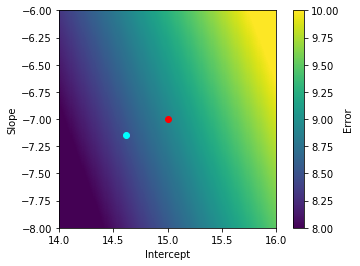

In [22]:
learning_rate = 0.4
position = np.array((intercept, slope))

# Gradient descent step
new_position = position - learning_rate*gradient

new_intercept, new_slope = new_position
plot_local_error(x_data, y_data, intercept, slope)
plt.plot([new_intercept], [new_slope], c='cyan', marker='o')

### Visualize the new local error surface

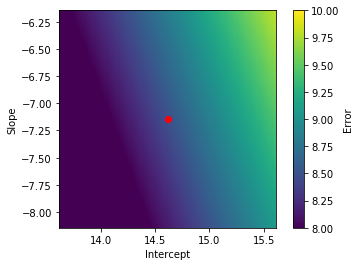

In [23]:
plot_local_error(x_data, y_data, new_intercept, new_slope)

### Do many gradient descent steps, storing the parameters obtained for each step

In [24]:
%%time

num_iterations = 170
learning_rate = 0.5

position = np.array((intercept, slope))
position_values = np.zeros((num_iterations, 2))
position_values[0] = position
for i in range(1, num_iterations):
    gradient = calculate_gradient(x_data, y_data, position[0], position[1])
    position = position - learning_rate*gradient
    position_values[i] = position

CPU times: user 8.01 ms, sys: 3.98 ms, total: 12 ms
Wall time: 10.6 ms


### Visualize the evolution of the intercept and slope parameters

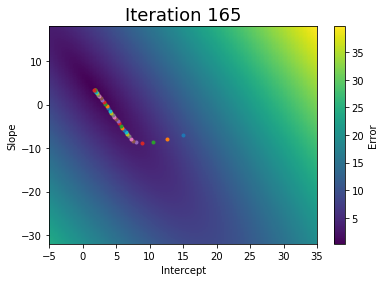

In [26]:
from IPython import display

local_error, X, Y = get_local_error(x_data, y_data, intercept, slope, range_intercept=20, range_slope=25)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.pcolormesh(X, Y, local_error)
cbar = plt.colorbar()
cbar.set_label('Error')
plt.xlabel('Intercept')
plt.ylabel('Slope')
for i in range(0, num_iterations, 5):
    ax.plot([position_values[i][0]], [position_values[i][1]], 'o', ms=3)
    ax.set_title('Iteration %d'%(i), size=18)
    display.display(fig)
    display.clear_output(wait=True)    


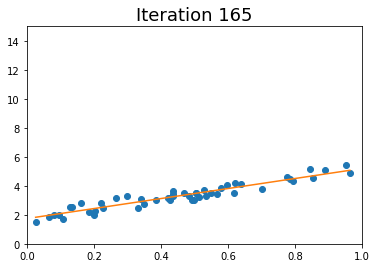

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(0, num_iterations, 5):
    est_intercept, est_slope = position_values[i]
    y_fit = est_slope*x_fit + est_intercept

    ax.clear()
    ax.plot(x_data, y_data, 'o')
    ax.plot(x_fit, y_fit)
    ax.set_title('Iteration %d'%(i), size=18)
    ax.set_xlim((0,1))
    ax.set_ylim((0,15))
    display.display(fig)
    display.clear_output(wait=True)     